# Quality assessment for spatial gene expression imputation and uncertainty calibration

This notebook contains some code for running TISSUE quality assessment and SpaGE imputation performance assessment. It borrows heavily from code from the TISSUE Github: https://github.com/sunericd/TISSUE and https://github.com/sunericd/tissue-figures-and-analyses. This is an archival notebook (uses an old TISSUE version before the first package version).

**Associated manuscript figures/tables:**
- Figures: 5b
- Extended Data Figures: 10a

**Inputs required:**
- Assorted data files in the `results/for_imputation/` directory
- Outputs generated from `spatial_conformal_uncertainty.py` followed by `get_calibration.py`


**Conda environment used**: `requirements/merfish.txt`


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr, levene
import anndata as ad
import seaborn as sns
import pickle
import os

os.chdir("results/for_imputation/")

from TISSUE.tissue.main import *
from TISSUE.tissue.utils import *
from TISSUE.tissue.experiments import measure_calibration_error

In [4]:
#### Swap dataset names to real identifiers
dataset_mapper = {"SVZ": "Buckley et al. (2023)"}

method_mapper = {"tangram": "Tangram",
                 "spage": "SpaGE",
                 "knn": "Harmony",
                 "gimvi": "gimVI"}
#### 

# SpaGE prediction performance

In [58]:
datasets = ["SVZ"]
methods = ['spage']

gene_col = []
dataset_col = []
method_col = []
R_col = []
Spearman_col = []
MAE_col = []
levene_nsc_col = []
levene_tcell_col = []

# loop through datasets
for d in datasets:
    
    # read results
    adata = sc.read_h5ad("SCPI_k4_k1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    
    # get dimensions
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    # loop through each prediction model
    for method in methods:
        
        # get predicted and actual expression
        imputed = np.array(adata.obsm[method+"_predicted_expression"])
        actual = adata[:,adata.obsm[method+"_predicted_expression"].columns].X
        
        # compute statistics for each gene in the dataset
        for j in range(adata.obsm[method+"_predicted_expression"].shape[1]):
            not_nans = (~np.isnan(imputed[:,j]) & ~np.isnan(actual[:,j]))
            
            # compute stats
            r, p = pearsonr(imputed[not_nans,j], actual[not_nans,j])
            rho, p = spearmanr(imputed[:,j], actual[:,j])
            mae = np.nanmean(np.abs(imputed[:,j]-actual[:,j]))
            lstat, lp_nsc = levene(imputed[adata.obs['proximity to NSC']=="Near",j],
                               imputed[adata.obs['proximity to NSC']=="Far",j],
                               center='median', proportiontocut=0.05)
            lstat, lp_tcell = levene(imputed[adata.obs['proximity to T cell']=="Near",j],
                               imputed[adata.obs['proximity to T cell']=="Far",j],
                               center='median', proportiontocut=0.05)
            name = dataset_mapper[d]
            
            # append results
            #dataset_col.append(name+f"\nn={n_cells}\np={n_genes}") # add n_cell/n_gene info
            gene_col.append(adata.obsm[method+"_predicted_expression"].columns[j])
            dataset_col.append(name)
            method_col.append(method_mapper[method])
            R_col.append(r)
            Spearman_col.append(rho)
            MAE_col.append(mae)
            levene_nsc_col.append(lp_nsc)
            levene_tcell_col.append(lp_tcell)
            
            
# compile into dataframe for plotting
df = pd.DataFrame([])
df["Gene"] = gene_col
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Pearson"] = R_col
df["Spearman"] = Spearman_col
df["MAE"] = MAE_col
df["MAE"] = df["MAE"].astype(float)
df["log MAE"] = np.log(df["MAE"])
df["Levene P-value (NSC)"] = levene_nsc_col
df["Levene P-value (T cell)"] = levene_tcell_col

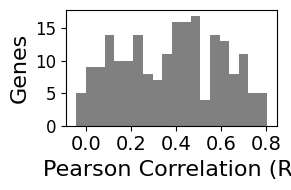

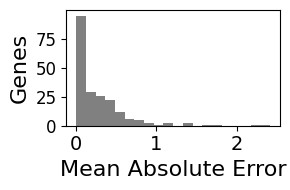

In [59]:
# Pearson
plt.figure(figsize=(3,2))
#sns.violinplot(x="Dataset", y="Pearson", color="0.8", data=df)
plt.hist(df[df["Method"]=="SpaGE"]["Pearson"], bins=20, facecolor='0.5')
plt.ylabel("Genes", fontsize=16)
plt.xlabel("Pearson Correlation (R)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
#plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('../../plots/mechanism/SpaGE_histo_Pearson.pdf', dpi=300, bbox_inches='tight')
plt.show()

# MAE
plt.figure(figsize=(3,2))
plt.hist(df[df["Method"]=="SpaGE"]["MAE"], bins=20, facecolor='0.5')
plt.ylabel("Genes", fontsize=16)
plt.xlabel("Mean Absolute Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
#plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('../../plots/mechanism/SpaGE_histo_MAE.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Equality of variances in imputed gene expression

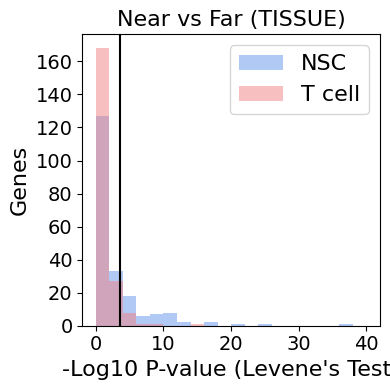

In [60]:
plt.figure(figsize=(4,4))
plt.axvline(-np.log10(0.05/df.shape[0]), color='k')
plt.hist(-np.log10(df["Levene P-value (NSC)"]), color='cornflowerblue',
        alpha=0.5, range=(0,40), bins=20, label="NSC")
plt.hist(-np.log10(df["Levene P-value (T cell)"]), color='lightcoral',
        alpha=0.5, range=(0,40), bins=20, label="T cell")
plt.title("Near vs Far (TISSUE)", fontsize=16)
plt.xlabel("-Log10 P-value (Levene's Test)", fontsize=16)
plt.ylabel("Genes", fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('../../plots/mechanism/SpaGE_levene_p.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [61]:
cutoff = 0.05/df.shape[0]
print(np.sum(df["Levene P-value (NSC)"].values<cutoff)/df.shape[0])
print(np.sum(df["Levene P-value (T cell)"].values<cutoff)/df.shape[0])

0.2524271844660194
0.07766990291262135
